# Continuous control
## DDPG algorithm implementation

---

This self sufficient contains the whole code needed for an implementation of the DDPG reinforcement learning algorithm in the "reacher environment".

We follow the implementation described in the paper "Continuous control with reinforcement learning": https://arxiv.org/abs/1509.02971

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from collections import namedtuple, deque
import random
from matplotlib import pyplot as plt
import pickle
from IPython import display
import pylab as pl
import copy
import time

%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Depending on which version of the environment you want to run, select one line or the other in the cell below:

In [2]:
# Select this option to load version 1 (with a single agent) of the environment
# env = UnityEnvironment(file_name='/Users/manuelsh/code/deep-reinforcement-learning/p2_continuous-control/Reacher.app')

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/Users/manuelsh/code/deep-reinforcement-learning/p3_collab-compet/Tennis.app')

# Get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


### Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### Implementation of relevant classes
In the following cells we implement the ReplayBuffer class (coming from the Udacity repo), Ornstein Uhlenbeck noise generation, soft-update function (which updates the parameters of the target function) and the classes for the actor (`DeterministicPolicy`) and the critic (`QFunction`).

In [4]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
            e = self.experience(state, action, reward, next_state, done)
            self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""

class RandomProcess():
    def __init__(self, num_agents, action_size, decay_rate, multiplier):
        self.num_agents = num_agents
        self.action_size = action_size
        self.decay_rate = decay_rate
        self.multiplier = multiplier
    
    def sample(self):
        self.multiplier *= self.decay_rate
        return (np.random.randn(num_agents, action_size) * self.multiplier)[0]

In [5]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0, sigma=0.2, num_agents=num_agents, num_actions=action_size):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.num_agents=num_agents
        self.num_actions=num_actions
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state.reshape(self.num_agents,self.num_actions)

In [6]:
def soft_update(local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


In [7]:
class QFunction(nn.Module):
    def __init__(self, state_dim, actions_dim, hidden_units=(400, 300,200), activation=F.relu):
        super(QFunction, self).__init__()
        dims = (state_dim + actions_dim, ) + hidden_units + (1, )
        self.layers = nn.ModuleList(
            [nn.Linear(dim_in, dim_out) for dim_in, dim_out in zip(dims[:-1], dims[1:])])
        self.activation = activation      
        
    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        return self.layers[-1](x)

In [8]:
class DeterministicPolicy(nn.Module):
    def __init__(self, state_dim, actions_dim, hidden_units=(400, 300,200) , activation=F.relu):
        super(DeterministicPolicy, self).__init__()
        dims = (state_dim,) + hidden_units +(actions_dim,)
        self.layers = nn.ModuleList(
            [nn.Linear(dim_in, dim_out) for dim_in, dim_out in zip(dims[:-1], dims[1:])])
        self.activation = activation      
        
    def forward(self, state):
        x = state
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        return F.tanh( self.layers[-1](x) )

In [9]:
def perform_an_action(states, noise_sample):
        # perform an action
        states_tensor = torch.FloatTensor(states).to(device)
        actions = agent(states_tensor).detach().cpu().numpy() + noise_factor*noise_sample
        env_info = env.step(actions)[brain_name]
        next_noise = noise.sample()*noise_factor
        next_states = np.append(env_info.vector_observations, next_noise,1)        
        rewards = env_info.rewards                         
        dones = env_info.local_done
        return states, actions, rewards, next_states, dones, next_noise      

In [10]:
def watch_env():
    time.sleep(0.1)
    env_info = env.reset(train_mode=False)[brain_name]      # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    noise.reset()
    noise_sample = noise.sample()
    states = np.append(states, noise_sample, 1)
    for i in range(t_max):
        states, actions, rewards, next_states, dones, next_noise = perform_an_action(states, noise_sample)
        scores += rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        time.sleep(0.01)
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

### Parameters, instantiation and training loop

In [11]:
# Main parameters:

BUFFER_SIZE = int(1e5)
BATCH_SIZE = 256      

gamma = 0.99
tau = 0.001
lr_critic = 1E-3
lr_agent = 1E-3
update_steps = 1
num_updates = 1
noise_factor = 1
t_max = 100

# Instantiation
critic = QFunction(state_size+action_size, action_size).to(device)
agent = DeterministicPolicy(state_size+action_size, action_size).to(device)

critic_target = QFunction(state_size+action_size, action_size).to(device)
agent_target = DeterministicPolicy(state_size+action_size, action_size).to(device)

critic_target.load_state_dict(critic.state_dict())
agent_target.load_state_dict(agent.state_dict())

replay_buffer = ReplayBuffer(action_size=action_size, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, seed=88)

critic_loss_function = torch.nn.MSELoss()
critic_optimizer = torch.optim.Adam(critic.parameters(), lr=lr_critic)
agent_optimizer = torch.optim.Adam(agent.parameters(), lr=lr_agent)

noise = OUNoise(num_agents*action_size, 88)

total_scores = []
total_scores_queue = deque(maxlen=100)
running_averages = []

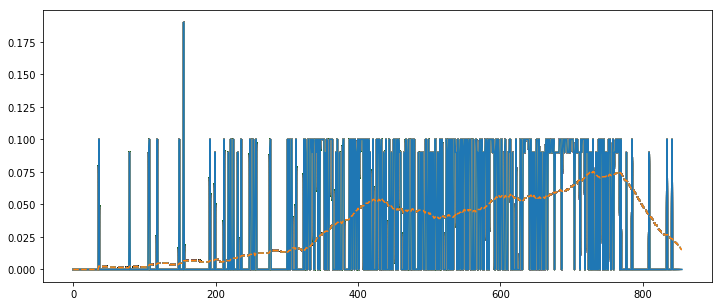

Running average episode 856: 0.015300000254064798


KeyboardInterrupt: 

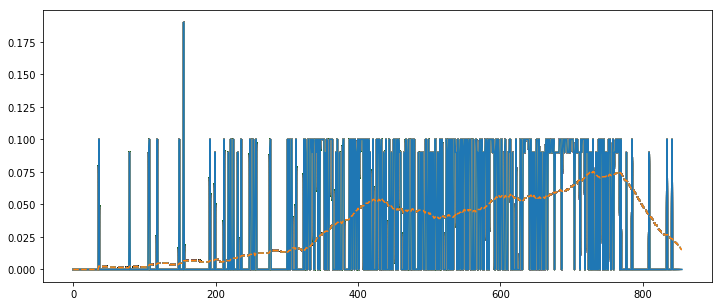

In [12]:
num_episodes = 2000
step_counter = 0
pl.figure(figsize=(12,5))
for episode in range(num_episodes):
    env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    noise.reset()
    noise_sample = noise.sample()*noise_factor
    states = np.append(states, noise_sample, 1)
    while True:
        states, actions, rewards, next_states, dones, next_noise = perform_an_action(states, noise_sample)
        replay_buffer.add(state=states, 
                  action=actions, 
                  reward=rewards, 
                  next_state=next_states, 
                  done=dones)
        scores += rewards                         # update the score (for each agent)
        states = next_states                    # roll over states to next time step 
        noise_sample = next_noise
        step_counter+=1
        
        if (len(replay_buffer.memory)>BATCH_SIZE) & (step_counter%update_steps==0) :
            for i in range(num_updates):
                # Train the critic
                states_r, actions_r, rewards_r, next_states_r, dones_r = replay_buffer.sample()
                #next_state_tensor = torch.FloatTensor(next_states)
                y = rewards_r + \
                    gamma * critic_target(next_states_r, agent_target(next_states_r))
                y=y.detach()
                critic_loss_value = critic_loss_function(critic(states_r, actions_r), y)
                critic_optimizer.zero_grad()
                critic_loss_value.backward()
                critic_optimizer.step()

                # Train the agent
                agent_loss_value = -critic(states_r, agent(states_r)).mean()
                agent_optimizer.zero_grad()
                agent_loss_value.backward()
                agent_optimizer.step()

                # Update parameters
                soft_update(agent, agent_target, tau)
                soft_update(critic, critic_target, tau)
               
        if np.any(dones):                                  # exit loop if episode finished
            break
            
    #print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))
    total_scores.append(np.max(scores))
    total_scores_queue.append(np.max(scores))
    running_average = np.mean(total_scores_queue)
    running_averages.append(running_average)
    pickle.dump(total_scores, open('total_scores.pickle','wb'))
    pickle.dump(running_average, open('running_average.pickle','wb'))
    display.clear_output(wait=True)
    pl.plot(total_scores, label='Episode score')
    pl.plot(running_averages, label='Running average score, 100 episodes', linestyle='--')
    display.display(pl.gcf())
    print(f'Running average episode {len(total_scores)}: {running_average}')
    if running_average>=0.5:
        print(f'Problem solved at episode {len(total_scores)}')
        break
        
    if len(total_scores)%25==0:
        watch_env()

### Saves parameters of model

In [13]:
torch.save(agent.state_dict(), 'models-parameters/agent_reacher.torch')
torch.save(critic.state_dict(), 'models-parameters/critic_reacher.torch')
torch.save(agent_target.state_dict(), 'models-parameters/agent_target_reacher.torch')
torch.save(critic_target.state_dict(), 'models-parameters/critic_target_reacher.torch')

In [14]:
time.sleep(0.1)
env_info = env.reset(train_mode=False)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
noise.reset()
noise_sample = noise.sample()
states = np.append(states, noise_sample, 1)
while True:
    states, actions, rewards, next_states, dones, next_noise = perform_an_action(states, noise_sample)
    scores += rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    time.sleep(0.01)
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

KeyboardInterrupt: 